In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastbook fastai duckduckgo_search;

Import packages

In [2]:
#|export
import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.vision.widgets import *
from duckduckgo_search import DDGS
from fastcore.all import *

Define the test set

In [3]:
architecture_styles = ['brutalism', 'modernism']

image_urls = {
    'brutalism': 'https://mymodernmet.com/wp/wp-content/uploads/2018/11/brutalist-architecture-4.jpg',
    'modernism': 'https://thishousedoesnotexist.org/assets/houses/5064608.png?_1663639383'

}

destinations = {
    'brutalism': 'images/brutalism.jpg',
    'modernism': 'images/modernism.jpg'
}

Download the test set

In [25]:
for url in image_urls:
    download_url(image_urls[url], destinations[url])

Download the training set 

In [7]:
def search_images(term, max_image=150):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_image)).itemgot('image')

path = Path('styles')
from time import sleep

for i in architecture_styles:
    dest = (path/i)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{i} architecture'))
    sleep(10)
    resize_images(path/i, max_size=400, dest=path/i)

Remove broken images

In [27]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

Count of images we're going to train the model on

In [28]:
image_files = get_image_files(path)
len(image_files)

286

In [5]:
buildings = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [8]:
dls = buildings.dataloaders(path)

Validation set

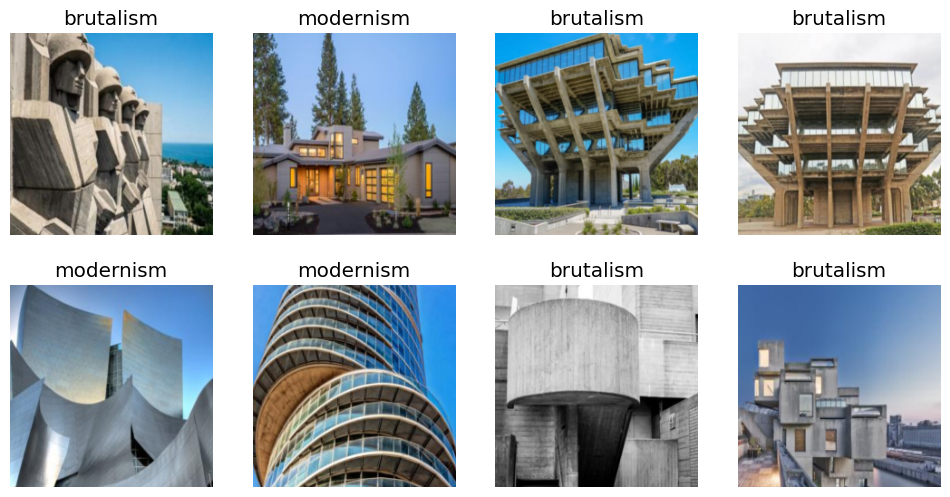

In [9]:
dls.valid.show_batch(max_n=8, nrows=2)

Training set

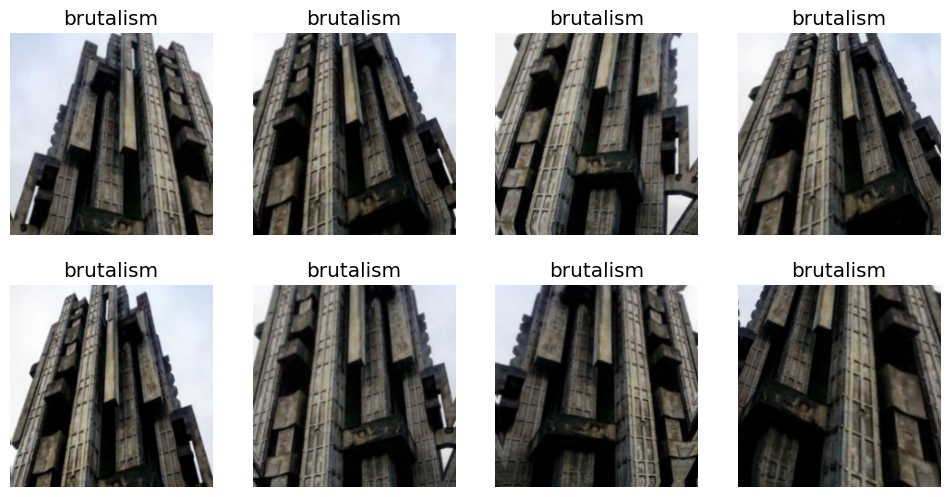

In [10]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
# learn.fine_tune(20)

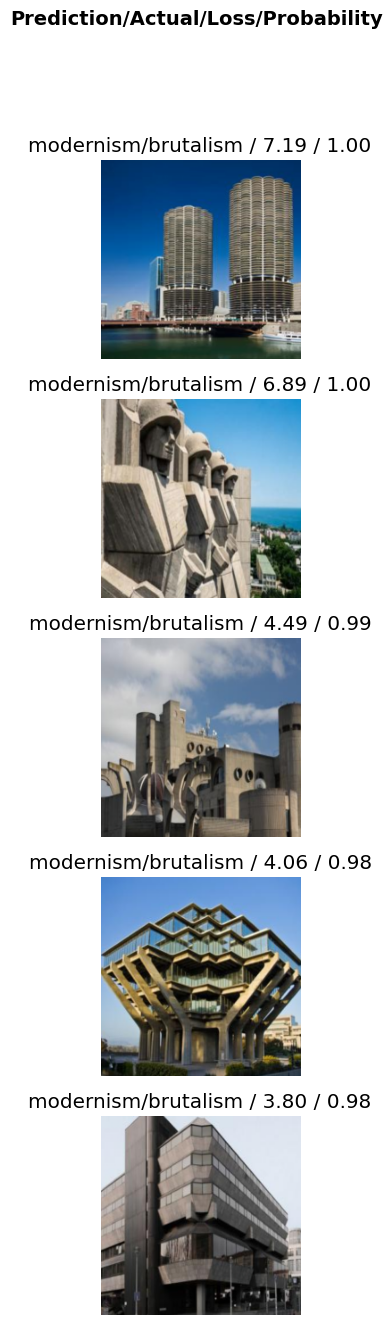

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=5)

In [17]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [19]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)    

Architectural style: brutalism


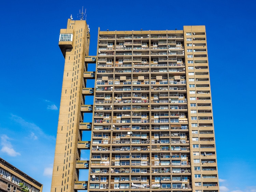

In [37]:
brutalism = destinations['brutalism']
modernism = destinations['modernism']
image = brutalism

architecture_style,_,probs = learn.predict(image)
print(f'Architectural style: {architecture_style}')
Image.open(image).to_thumb(256)

In [36]:
learn.export('brutalism_or_modernism.pkl')